# Superdense Coding
In this code we simulate the superdense coding protocol between two parties named "Alice" and "Bob". It consists of Alice sending two classical bits of information to Bob while sending only one qubit.

To do this they must, in advance, share an entangled Bell pair. Alice then applies gates to her qubit depending on what are the pair of clasical bits of information she wants to send. If the pair is $00$ she just send her qubit to Bob, if the second bit is $1$ she applies the $X$ gate, and if the first bit is $1$ she then applies a $Z$ gate before sending it to Bob. Upon receiving the qubit Bob performs a Bell measurement and he will get the two classical bits Alice wanted to send.

In [78]:
%matplotlib inline

from qiskit import *
from qiskit.tools.monitor import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-01-11 03:35:33,353: Credentials are already in use. The existing account in the session will be replaced.


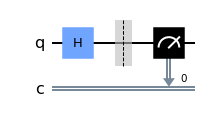

In [79]:
# First let us define the random bits generator to define what are the pair of classical bits Alice will send
rand = QuantumCircuit(1, 1)

rand.h(0)
rand.barrier()
rand.measure(0, 0)

rand.draw(output = 'mpl')

In [80]:
# Now we generate the 2 bits Alice will send to Bob
backend = Aer.get_backend('qasm_simulator')
job = execute(rand, backend, shots = 2, memory = True)
bits_a = [int(i) for i in job.result().get_memory()]
print(bits_a)

[1, 1]


In [81]:
# Now we create a function for contructing the circuit based on the pair of bits Alice wants to send
def send_bits(b1, b2):
    circ = QuantumCircuit(2, 2)
    
    # First  we set the Bell state
    circ.h(0)
    circ.cx(0, 1)
    circ.barrier()
    
    # Alice applies gates based on the classical bits
    if b2 == 1:
        circ.x(0)
    if b1 == 1:
        circ.z(0)
    circ.barrier()
    
    # Alice send her qubit to Bob and he performs a Bell measurement
    circ.cx(0, 1)
    circ.h(0)
    circ.measure([0, 1], [1, 0])

    return circ

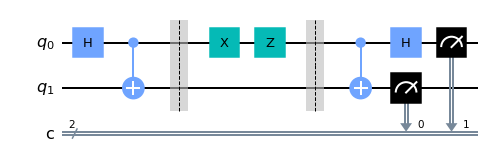

In [82]:
# We define the circuit
circ = send_bits(bits_a[0], bits_a[1])
circ.draw(output = 'mpl')

Bits sent by Alice:  [1, 1]
{'11': 1024}


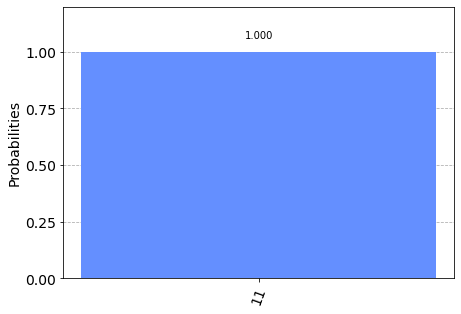

In [83]:
# First we run it in a simulator to check if Bob indeed receives the intended bits
backend = Aer.get_backend('qasm_simulator')
job_sim = execute(circ, backend, shots = 1024)
res_sim = job_sim.result()
counts_sim = res_sim.get_counts()

print("Bits sent by Alice: ", bits_a)
print(counts_sim)
plot_histogram(counts_sim)

Executing on: ibmqx2
Job Status: job has successfully run
Bits sent by Alice:  [1, 1]
{'00': 20, '01': 99, '10': 61, '11': 844}


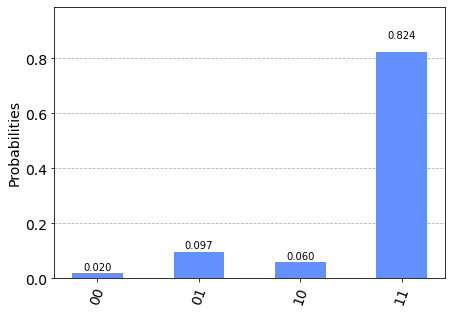

In [84]:
# Now we run it on a real IBM quantum computer
backend = least_busy(provider.backends(operational = True, simulator = False, status_msg = 'active',
                            filters = lambda x: x.configuration().n_qubits >= 2))
print('Executing on:', backend)
job_real = execute(circ, backend, shots = 1024)
job_monitor(job_real)

res_real = job_real.result()
counts_real = res_real.get_counts()

print("Bits sent by Alice: ", bits_a)
print(counts_real)
plot_histogram(counts_real)

Bits sent by Alice:  [1, 1]


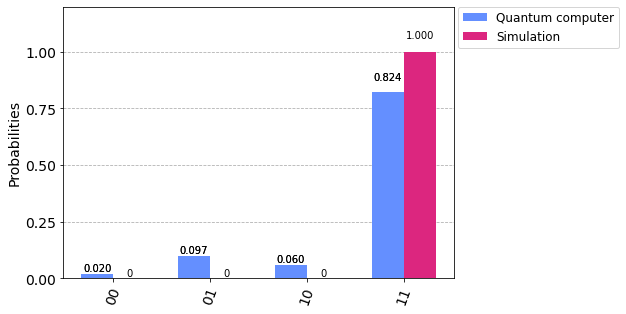

In [85]:
# For the sake of comparison we plot both histograms together
print("Bits sent by Alice: ", bits_a)
plot_histogram([counts_real, counts_sim], legend = ['Quantum computer', 'Simulation'])